In [1]:
# The C2QA pacakge is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Bose Hubbard model

In [2]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import evo
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

# Create a circuit with modes

In [3]:
numberofmodes=5
numberofqubits=numberofmodes
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

sm = [0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(sm[i], qmr[i])

In [4]:
def bch(circuit, qm, qb, U, dt):
    circuit.cv_qdcrX((U/2)*dt, qm, qb)
    circuit.cv_qdcr((U/2)*dt, qm, qb)
    circuit.cv_qdcrX(-(U/2)*dt, qm, qb)
    circuit.cv_qdcr(-(U/2)*dt, qm, qb)

def eiht(circuit, qma, qmb, qba, qbb, J, U, mu, dt):
    circuit.cv_bs(-J*dt, qmb, qma)
    circuit.cv_r(-((U/2)+mu)*dt, qma)
    circuit.cv_r(-((U/2)+mu)*dt, qmb)
    bch(circuit, qma, qba, U/2, dt)
    bch(circuit, qmb, qbb, U/2, dt)
    return circuit

In [5]:
def trotterise_BH(circuit, numberofmodes, numberofqubits, qmr, qbr, cutoff, N, J, U, mu, dt):
    occs=[np.zeros((N,numberofmodes)),np.zeros((N,numberofqubits))]

    # Trotterise. i*dt corresponds to the timestep i of length from the previous timestep dt.
    for i in range(N):
        print("dt+1", i*dt)
        # Trotterise according to the brickwork format to make depth of circuit 2 and not number of timesteps (because each site needs to be part of a gate with the site to the left and a gate with the site to the right.
        for j in range(0,numberofmodes-1,2):
            eiht(circuit, qmr[j+1], qmr[j], qbr[j], qbr[j+1], J, U, mu, dt)
        for j in range(1,numberofmodes-1,2):
            eiht(circuit, qmr[j+1], qmr[j], qbr[j], qbr[j+1], J, U, mu, dt)
        stateop, result = c2qa.util.simulate(circuit)
        occupation = util.stateread(stateop, qbr.size, numberofmodes, 4,verbose=False)
        occs[0][i]=np.array(list(occupation[0]))
        occs[1][i]=np.array(list(occupation[1]))

    return occs

In [6]:
dt=0.1
N=15

J=1
U=0.1
mu=1

occupations = trotterise_BH(circuit, numberofmodes, numberofqubits, qmr, qbr, cutoff, N, J, U, mu, dt)

dt+1 0.0


/Users/eleanorcrane/opt/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/eleanorcrane/opt/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


dt+1 0.1
dt+1 0.2
dt+1 0.30000000000000004
dt+1 0.4
dt+1 0.5
dt+1 0.6000000000000001
dt+1 0.7000000000000001
dt+1 0.8
dt+1 0.9
dt+1 1.0
dt+1 1.1
dt+1 1.2000000000000002
dt+1 1.3
dt+1 1.4000000000000001


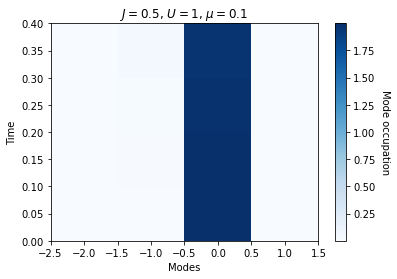

In [7]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("$J=0.5$, $U=1$, $\mu=0.1$")
plt.xlabel("Modes")
plt.ylabel("Time")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label("Mode occupation", rotation=270)

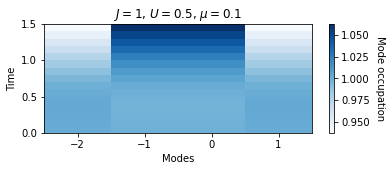

In [21]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("$J=1$, $U=0.5$, $\mu=0.1$")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.xticks([-2,-1,0,1])
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label("Mode occupation", rotation=270)
plt.rcParams["figure.figsize"] = (6,3)

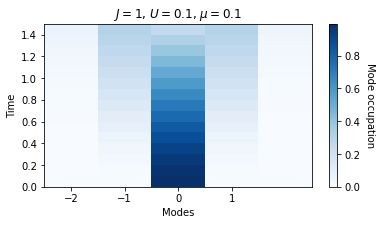

In [8]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("$J=1$, $U=0.1$, $\mu=0.1$")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.xticks([-2,-1,0,1])
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label("Mode occupation", rotation=270)
plt.rcParams["figure.figsize"] = (6,2)

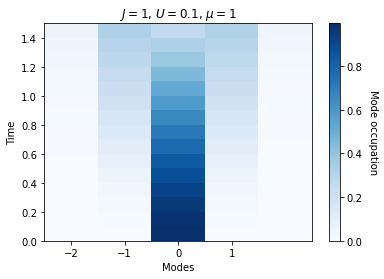

In [7]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("$J=1$, $U=0.1$, $\mu=1$")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.xticks([-2,-1,0,1])
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label("Mode occupation", rotation=270)
plt.rcParams["figure.figsize"] = (6,2)